In [61]:
# Imports

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [62]:
# Dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Device Setup

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("학습을 진행하는 기기 : ",device)

학습을 진행하는 기기 :  cuda:0


In [64]:
print('cuda index:', torch.cuda.current_device())

print('gpu 개수:', torch.cuda.device_count())

print('graphic name:', torch.cuda.get_device_name())

cuda = torch.device('cuda')

print(cuda)

cuda index: 0
gpu 개수: 1
graphic name: NVIDIA GeForce RTX 3070 Ti
cuda


In [65]:
print(torch.cuda.is_available())

True


In [122]:
# Network Model

import torch.nn as nn
import torch.nn.functional as F

class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    
        
        self.avgPool = nn.AvgPool2d(5)
        self.classifier = nn.Linear(16, 10)
        
        
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        # self.avg_pool = nn.AvgPool2d(10)
        # self.classifier = nn.Linear(16, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        features = self.conv2(x)
    
        x = self.avgPool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        
        return x, features
    
net = BasicNet().to(device)

In [115]:
# New Network Model

import torch.nn as nn
import torch.nn.functional as F

class LeNet_2(nn.Module):
    def __init__(self):
        super().__init__()
        # 32px 이었다가, conv를 거치면서 절반으로 감소
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
net = LeNet_2().to(device)

In [116]:
# Loss and Optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [117]:
# Train the Model

def train(e):
    for epoch in range(e):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs=net(inputs)[0]
            loss = criterion(outputs, labels)
            loss.item()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if i % 2000 == 1999:
                print("[%d %5d] loss: %.3f" % (epoch + 1, i+1, running_loss / 2000))
                running_loss=0.0
            
    print("Finished Training")

In [120]:
# Test the Model

def test():
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)[0]
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print("Accuracy of the network on the 10,000 test images: %d %%" %(100 * correct/total))

In [123]:
train(2)

[1  2000] loss: 2.325
[1  4000] loss: 2.324
[1  6000] loss: 2.320
[1  8000] loss: 2.322
[1 10000] loss: 2.324
[1 12000] loss: 2.324
[2  2000] loss: 2.322
[2  4000] loss: 2.325
[2  6000] loss: 2.319
[2  8000] loss: 2.325
[2 10000] loss: 2.325
[2 12000] loss: 2.322
Finished Training


In [124]:
torch.save(net.state_dict(), 'cifar.pkl')

In [125]:
test()

Accuracy of the network on the 10,000 test images: 10 %


In [126]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

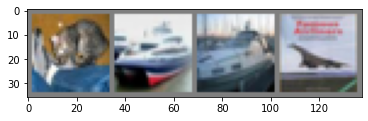

Ground Truth: cat ship ship plane 
Predicted: cat ship ship ship 


In [94]:
dataiter = iter(testloader)

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("Ground Truth:", "".join("%s " % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))[0]

_, predicted = torch.max(outputs, 1)

print("Predicted:", "".join("%s " % classes[predicted[j]] for j in range(4)))

torch.Size([6, 14, 14])
torch.Size([32, 5, 5])


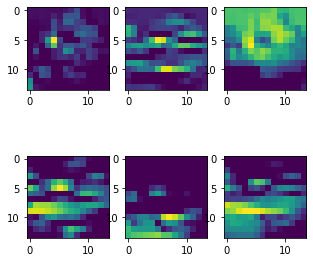

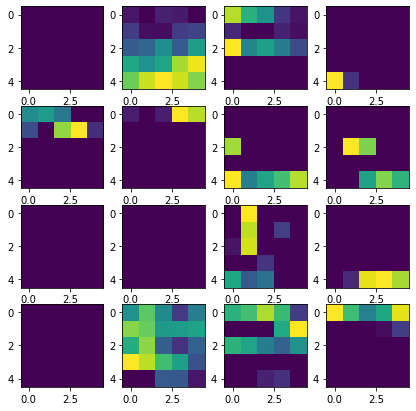

In [95]:
# Intermediate Feature Space

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))

data, _ = testset[1]
data.unsqueeze_(0)
output = net(data.to(device))[0]


act = activation['conv1'].squeeze()
act2 = activation['conv2'].squeeze()

print(act.shape)
print(act2.shape)

row, col = 2, 3

fig, axarr = plt.subplots(row, col, figsize=(5, 5))

for i in range(row):
    for j in range(col):
        axarr[i][j].imshow(act[i*col+j].cpu())
        
row, col = 4, 4
        
fig2, axarr2 = plt.subplots(row, col, figsize=(7, 7))
for i in range(row):
    for j in range(col):
        axarr2[i][j].imshow(act2[i*col+j].cpu())

torch.Size([1, 16, 5, 5])


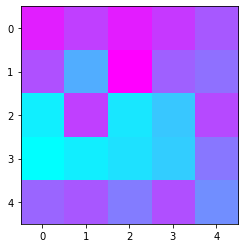

In [127]:
# CAM
image, label = testset[1]
batch_img = image[None, :, :, :].to(device)

x, map = net(batch_img)

print(map.shape)

class_weight = net.classifier.weight[int(label)].unsqueeze(-1).unsqueeze(-1)
cam_ = torch.squeeze(map) * class_weight

cam = torch.sum(cam_, axis=0)
cam = cam.detach().cpu().numpy()

plt.imshow(cam, cmap="cool", interpolation="nearest")
plt.show()

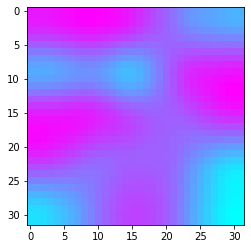

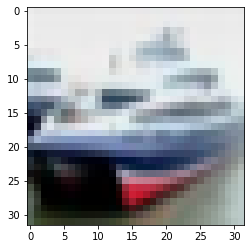

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


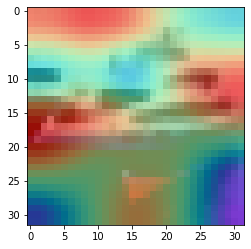

In [97]:
import cv2

resize_cam = cv2.resize(cam, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.imshow(resize_cam, cmap="cool", interpolation="nearest")
plt.show()

imshow(image)

origin = image.detach().numpy()

plt.imshow(np.rollaxis(origin, 0, 3))
plt.imshow(resize_cam, alpha=0.6, cmap="rainbow")
plt.show()